Reading classics [Deep Learning Models](https://github.com/rasbt/deeplearning-models)
## Code Modules & Functions

In [1]:
import numpy as np,pandas as pd,pylab as pl
import h5py,torch
from torchvision.datasets import MNIST as tmnist
from torchvision import transforms
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
import torch.nn.functional as tnnf
from sklearn.datasets import make_classification
from IPython.core.magic import register_line_magic
dev=torch.device("cuda:0" if torch.cuda.is_available() 
                 else "cpu")

In [2]:
def model_acc(model,data_loader,num_features):
    correct_preds,num_examples=0,0    
    for features,targets in data_loader:
        features=features.view(-1,num_features).to(dev)
        targets=targets.to(dev)
        logits,probs=model(features)
        _,pred_labels=torch.max(probs,1)
        num_examples+=targets.size(0)
        correct_preds+=(pred_labels==targets).sum()        
    return correct_preds.float()/num_examples*100

In [3]:
@register_line_magic
def print_acc(t):
    if t=='test':
        print('Test accuracy: %.4f%%'%\
        (model_acc(model,test_loader,num_features)))
    if t=='train':
        print('Train accuracy: %.4f%%'%\
        (model_acc(model,train_loader,num_features)))
@register_line_magic
def print_acc2(t):
    if t=='test':
        print('Test accuracy: %.4f%%'%\
        (model_acc(model,test_loader2,num_features2)))
    if t=='train':
        print('Train accuracy: %.4f%%'%\
        (model_acc(model,train_loader2,num_features2)))

In [4]:
@register_line_magic
def train_run(epochs):
    epochs=int(epochs)
    for epoch in range(epochs):
        for batch_ids,(features,targets) in enumerate(train_loader):        
            features=features.view(-1,num_features).to(dev)
            targets=targets.to(dev)
            logits,probs=model(features)
            cost=tnnf.cross_entropy(logits,targets)
            optimizer.zero_grad(); cost.backward()
            optimizer.step()
            if not batch_ids%300:
                print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                       %(epoch+1,epochs,batch_ids, 
                         len(train)//batch_size,cost))           
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d train accuracy: %.2f%%'%\
                  (epoch+1,epochs,model_acc(model,train_loader,
                                            num_features)))
@register_line_magic
def train_run2(epochs):
    epochs=int(epochs)
    for epoch in range(epochs):
        for batch_ids,(features,targets) in enumerate(train_loader2):        
            features=features.view(-1,num_features2).to(dev)
            targets=targets.to(dev)
            logits,probs=model(features)
            cost=tnnf.cross_entropy(logits,targets.long())
            optimizer.zero_grad(); cost.backward()
            optimizer.step()
            if not batch_ids%300:
                print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                       %(epoch+1,epochs,batch_ids, 
                         len(train2)//batch_size2,cost))           
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d train accuracy: %.2f%%'%\
                  (epoch+1,epochs,model_acc(model,train_loader2,
                                            num_features2)))

## Data

In [5]:
random_seed=1; batch_size=64
train=tmnist(root='data',train=True,download=True,
            transform=transforms.ToTensor())
test=tmnist(root='data',train=False, 
            transform=transforms.ToTensor())
train_loader=tdl(dataset=train,shuffle=True, 
                 batch_size=batch_size)
test_loader=tdl(dataset=test,shuffle=False, 
                batch_size=batch_size)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/opt/conda/conda-bld/pytorch_1587428190859/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [6]:
for images,labels in train_loader:  
    print('Image dimensions: %s'%str(images.shape))
    print('Label dimensions: %s'%str(labels.shape))
    break




Image dimensions: torch.Size([64, 1, 28, 28])
Label dimensions: torch.Size([64])


['test_images', 'test_labels', 'train_images', 'train_labels']



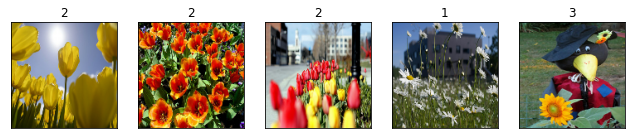

In [7]:
fpath='../input/image-classification-for-biospecies-2/'
f=h5py.File(fpath+'TfFlowerImages.h5','r')
keys=list(f.keys()); print(keys)
x_test=np.array(f[keys[0]])
y_test=np.array(f[keys[1]]).reshape(-1)
x_train=np.array(f[keys[2]])
y_train=np.array(f[keys[3]]).reshape(-1)
fig=pl.figure(figsize=(11,4))
n=np.random.randint(1,50); n_classes=5
for i in range(n,n+5):
    ax=fig.add_subplot(1,5,i-n+1,\
    xticks=[],yticks=[],title=y_test[i])
    ax.imshow((x_test[i]))

In [8]:
random_seed=1; batch_size2=64
class TData(tds):
    def __init__(self,X,y):   
        self.X=torch.tensor(X,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        train_img,train_lbl=self.X[index],self.y[index]
        return train_img,train_lbl
    def __len__(self):
        return self.y.shape[0]
train2=TData(x_train,y_train)
test2=TData(x_test,y_test)
train_loader2=tdl(dataset=train2,batch_size=batch_size2,shuffle=True)
test_loader2=tdl(dataset=test2,batch_size=batch_size2,shuffle=False)
for images,labels in train_loader2:  
    print('Image dimensions: %s'%str(images.shape))
    print('Label dimensions: %s'%str(labels.shape))
    break

Image dimensions: torch.Size([64, 128, 128, 3])
Label dimensions: torch.Size([64])


## MLP with BatchNormalization

In [9]:
num_features=784; num_classes=10
hidden1=512; hidden2=256; hidden3=128
class MLPN(torch.nn.Module):
    def __init__(self,num_features,num_classes):
        super(MLPN,self).__init__()
        self.linear1=torch.nn.Linear(num_features,hidden1)
        self.linear1.weight.detach().normal_(0.,.1)
        self.linear1.bias.detach().zero_()
        self.linear1bn=torch.nn.BatchNorm1d(hidden1)
        self.linear2=torch.nn.Linear(hidden1,hidden2)
        self.linear2.weight.detach().normal_(0.,.1)
        self.linear2.bias.detach().zero_()
        self.linear2bn=torch.nn.BatchNorm1d(hidden2)
        self.linear3=torch.nn.Linear(hidden2,hidden3)
        self.linear3.weight.detach().normal_(0.,.1)
        self.linear3.bias.detach().zero_()
        self.linear3bn=torch.nn.BatchNorm1d(hidden3)
        self.linear_out=torch.nn.Linear(hidden3,num_classes)
        self.linear_out.weight.detach().normal_(0.,.1)
        self.linear_out.bias.detach().zero_()        
    def forward(self,x):
        y=self.linear1(x); y=self.linear1bn(y)
        y=tnnf.relu(y)
        y=self.linear2(y); y=self.linear2bn(y)
        y=tnnf.relu(y)
        y=self.linear3(y); y=self.linear3bn(y)
        y=tnnf.relu(y)
        logits=self.linear_out(y)
        probs=tnnf.log_softmax(logits,dim=1)
        return logits,probs   
torch.manual_seed(random_seed)
model=MLPN(num_features=num_features,
           num_classes=num_classes)
model=model.to(dev); learning_rate=.01
optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate)

In [10]:
%train_run 20

Epoch: 001/020 | Batch 000/937 | Cost: 2.6883
Epoch: 001/020 | Batch 300/937 | Cost: 0.8777
Epoch: 001/020 | Batch 600/937 | Cost: 0.6616
Epoch: 001/020 | Batch 900/937 | Cost: 0.4860
Epoch: 001/020 train accuracy: 88.61%
Epoch: 002/020 | Batch 000/937 | Cost: 0.5335
Epoch: 002/020 | Batch 300/937 | Cost: 0.2813
Epoch: 002/020 | Batch 600/937 | Cost: 0.2545
Epoch: 002/020 | Batch 900/937 | Cost: 0.3163
Epoch: 002/020 train accuracy: 91.71%
Epoch: 003/020 | Batch 000/937 | Cost: 0.2939
Epoch: 003/020 | Batch 300/937 | Cost: 0.4080
Epoch: 003/020 | Batch 600/937 | Cost: 0.3479
Epoch: 003/020 | Batch 900/937 | Cost: 0.2484
Epoch: 003/020 train accuracy: 93.36%
Epoch: 004/020 | Batch 000/937 | Cost: 0.1365
Epoch: 004/020 | Batch 300/937 | Cost: 0.2304
Epoch: 004/020 | Batch 600/937 | Cost: 0.1656
Epoch: 004/020 | Batch 900/937 | Cost: 0.1502
Epoch: 004/020 train accuracy: 94.24%
Epoch: 005/020 | Batch 000/937 | Cost: 0.1942
Epoch: 005/020 | Batch 300/937 | Cost: 0.1671
Epoch: 005/020 | Bat

In [11]:
%print_acc train
%print_acc test

Train accuracy: 98.4317%
Test accuracy: 96.6800%


In [12]:
num_features2=128*128*3; num_classes2=5
hidden1=1024; hidden2=512; hidden3=256
class MLPN2(torch.nn.Module):
    def __init__(self,num_features,num_classes):
        super(MLPN2,self).__init__()
        self.linear1=torch.nn.Linear(num_features,hidden1)
        self.linear1.weight.detach().normal_(0.,.1)
        self.linear1.bias.detach().zero_()
        self.linear1bn=torch.nn.BatchNorm1d(hidden1)
        self.linear2=torch.nn.Linear(hidden1,hidden2)
        self.linear2.weight.detach().normal_(0.,.1)
        self.linear2.bias.detach().zero_()
        self.linear2bn=torch.nn.BatchNorm1d(hidden2)
        self.linear3=torch.nn.Linear(hidden2,hidden3)
        self.linear3.weight.detach().normal_(0.,.1)
        self.linear3.bias.detach().zero_()
        self.linear3bn=torch.nn.BatchNorm1d(hidden3)
        self.linear_out=torch.nn.Linear(hidden3,num_classes)
        self.linear_out.weight.detach().normal_(0.,.1)
        self.linear_out.bias.detach().zero_()        
    def forward(self,x):
        y=self.linear1(x); y=self.linear1bn(y)
        y=tnnf.relu(y)
        y=self.linear2(y); y=self.linear2bn(y)
        y=tnnf.relu(y)
        y=self.linear3(y); y=self.linear3bn(y)
        y=tnnf.relu(y)
        logits=self.linear_out(y)
        probs=tnnf.log_softmax(logits,dim=1)
        return logits,probs
torch.manual_seed(random_seed)
model=MLPN2(num_features=num_features2,
            num_classes=num_classes2)
model=model.to(dev); learning_rate=.001
optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate)

In [13]:
%train_run2 30

Epoch: 001/030 | Batch 000/051 | Cost: 2.1482
Epoch: 001/030 train accuracy: 19.41%
Epoch: 002/030 | Batch 000/051 | Cost: 2.2205
Epoch: 002/030 train accuracy: 20.04%
Epoch: 003/030 | Batch 000/051 | Cost: 1.8745
Epoch: 003/030 train accuracy: 22.34%
Epoch: 004/030 | Batch 000/051 | Cost: 1.8149
Epoch: 004/030 train accuracy: 23.49%
Epoch: 005/030 | Batch 000/051 | Cost: 1.6843
Epoch: 005/030 train accuracy: 25.43%
Epoch: 006/030 | Batch 000/051 | Cost: 1.7299
Epoch: 006/030 train accuracy: 27.10%
Epoch: 007/030 | Batch 000/051 | Cost: 1.5497
Epoch: 007/030 train accuracy: 28.64%
Epoch: 008/030 | Batch 000/051 | Cost: 1.6821
Epoch: 008/030 train accuracy: 29.25%
Epoch: 009/030 | Batch 000/051 | Cost: 1.5482
Epoch: 009/030 train accuracy: 30.76%
Epoch: 010/030 | Batch 000/051 | Cost: 1.4308
Epoch: 010/030 train accuracy: 31.64%
Epoch: 011/030 | Batch 000/051 | Cost: 1.6645
Epoch: 011/030 train accuracy: 33.06%
Epoch: 012/030 | Batch 000/051 | Cost: 1.3871
Epoch: 012/030 train accuracy:

In [14]:
%print_acc2 train
%print_acc2 test

Train accuracy: 46.2307%
Test accuracy: 34.8774%
